In [1]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import *


cellDir = r'C:\Users\Roarke\Desktop\University\2019 Semester 2 CURRENT\CITS4404\Project\RCNN\Mask_RCNN\cells' 

Using TensorFlow backend.


In [2]:
# class that defines and loads the cell dataset
class CellDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "cell")
        # img tags
        imgs = [2,6,7,15,17]
        # find all images
        if is_train:
            for files in imgs:
                images_dir = dataset_dir + '/cellTrainingData/image_' + str(files) +'/'
                annotations_dir = dataset_dir + '/cellTrainingData/image_' + str(files) + '_XML/'   
                for filename in listdir(images_dir):
                    # extract image id
                    image_id = filename[:-4]
                    img_path = images_dir + filename
                    ann_path = annotations_dir + image_id + '.xml'
                    # add to dataset
                    self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)    
        if not is_train: 
            images_dir = dataset_dir + '/cellTestData/image_20/'
            annotations_dir = dataset_dir + '/cellTestData/image_20_XML/'
            for filename in listdir(images_dir):
                image_id = filename[:-4]
                img_path = images_dir + filename
                ann_path = annotations_dir + image_id + '.xml'
                # add to dataset
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    def load_final(self, dataset_dir):
        self.add_class("dataset", 1, "cell")
        images_dir = dataset_dir + '/image/'
        annotations_dir = dataset_dir + '/annot/'
        for filename in listdir(images_dir):
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('cell'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
# define a configuration for the model
class CellConfig(Config):
    # define the name of the configuration
    NAME = "cell_cfg"
    # number of classes (background + cell)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 35 #131
    LEARNING_RATE = 0.002

In [3]:
# prepare train set
train_set = CellDataset()
train_set.load_dataset(cellDir, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = CellDataset()
test_set.load_dataset(cellDir, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = CellConfig()
#config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')

Train: 80
Test: 16



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=6, layers='heads')


Starting at epoch 0. LR=0.002

Checkpoint Path: ./cell_cfg20191009T1913\mask_rcnn_cell_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDis

c:\users\roarke\miniconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\roarke\miniconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\roarke\miniconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Epoch 1/6
 6/35 [====>.........................] - ETA: 1:50 - loss: 5.1227 - rpn_class_loss: 0.4638 - rpn_bbox_loss: 2.8448 - mrcnn_class_loss: 0.3821 - mrcnn_bbox_loss: 0.9195 - mrcnn_mask_loss: 0.5125


Instructions for updating:
Use `tf.cast` instead.


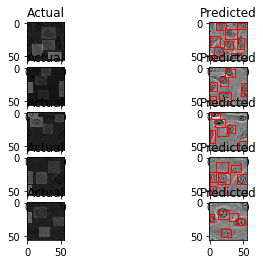

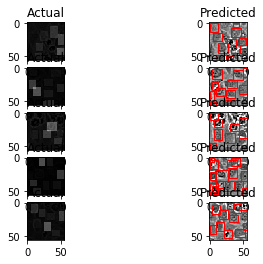

Train mAP: 0.667
Test mAP: 0.659


In [4]:
from numpy import mean
from numpy import expand_dims

from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

from matplotlib import pyplot
from matplotlib.patches import Rectangle



# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "cell_cfg"
    # number of classes (background + cell)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP    
    
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()
    
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_cell_cfg_0003.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
fig = plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
fig2 = plot_actual_vs_predicted(test_set, model, cfg)

# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

In [148]:
def gatherDATA(dataset, model, cfg, n_images=16):
    # load image and mask
    yhats = list()
    images = list()
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        yhats.append(yhat)
        images.append(image)
    return yhats,images

In [81]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [152]:
def stitchUp(images):
    imgArray = np.append(images[0],images[1],axis=1)
    for ii in range(1,3):
        imgArray = np.append(imgArray,images[ii+1],axis=1)

    imgArray2 = np.append(images[4],images[5],axis=1)
    for ii in range(5,7):
        imgArray2 = np.append(imgArray2,images[ii+1],axis=1)
    imgArrayAPP = np.append(imgArray,imgArray2,axis=0)

    imgArray3 = np.append(images[8],images[9],axis=1)
    for ii in range(9,11):
        imgArray3 = np.append(imgArray3,images[ii+1],axis=1)
    imgArrayAPP = np.append(imgArrayAPP,imgArray3,axis=0)

    imgArray4 = np.append(images[12],images[13],axis=1)
    for ii in range(13,15):
        imgArray4 = np.append(imgArray4,images[ii+1],axis=1)
    imgArrayAPP = np.append(imgArrayAPP,imgArray4,axis=0)    
    imgTest = array_to_img(imgArrayAPP)
    return imgTest

In [153]:
def plotBoxes(yhats):
    image = stitchUp(images)
    pyplot.title('Stitched Image')
    pyplot.imshow(image)
    ax = pyplot.gca()
    for jj in range(4):
        for ii in range(4):
            for box in yhats[ii]['rois']:
                # get coordinates
                y1, x1, y2, x2 = box
                # calculate width and height of the box
                width, height = x2 - x1, y2 - y1
                # create the shape
                rect = Rectangle((x1+(56*ii), y1+(56*jj)), width, height, fill=False, color='red')
                # draw the box
                ax.add_patch(rect)
    # show the figure
    pyplot.show()

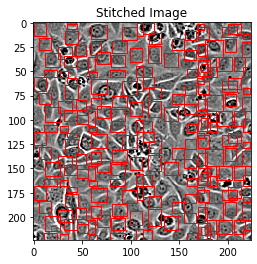

In [154]:
yhats,images = gatherDATA(test_set, model, cfg)
plotBoxes(yhats)